# Use a model trained on 2020 data to predict for 2019 train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset, DataLoader
from argparse import Namespace
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
from cassava.utils import *
from cassava.transforms import get_test_transforms
from cassava.models.model import LeafDoctorModel
from cassava.pipelines.train_model.nodes import score_model
from cassava.pipelines.train_model.nodes import split_data, train_model

In [4]:
parameters = context.catalog.load('parameters')

2020-12-29 13:53:23,993 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [5]:
parameters

{'seed': 42,
 'cv_splits': 4,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 6,
 'log_training': 1,
 'classifier': {'train_height': 320,
  'train_width': 320,
  'test_height': 400,
  'test_width': 400,
  'gpus': -1,
  'batch_size': 20,
  'accumulate_grad_batches': 1,
  'max_epochs': 20,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'bitempered_t1': 0.8,
  'bitempered_t2': 1.2,
  'label_smoothing': 0.1,
  'amp_level': 'O2',
  'precision': 16,
  'log_every_n_steps': 10,
  'flush_logs_every_n_steps': 100,
  'finetune': {'max_epochs': 10, 'lr': 0.0001}},
 'byol': {'width': 400,
  'height': 400,
  'gpus': -1,
  'batch_size': 12,
  'accumulate_grad_batches': 1,
  'max_epochs': 10,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'limit_train_batches': 100,
  'limit_val_batches': 1,
  'early_stop_patience': 3,
  'amp_level': '02',
  'precision': 16,
  'log_every_n_steps': 10,
 

In [6]:
train = context.catalog.load('train')

2020-12-29 13:53:24,531 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [7]:
duplicates = context.catalog.load('duplicates')

2020-12-29 13:53:26,321 - kedro.io.data_catalog - INFO - Loading data from `duplicates` (CSVDataSet)...


In [8]:
train_2020_indices = np.array(range(len(train)))[train.sources == 'train_2020']

In [9]:
train_2019_indices = np.array(range(len(train)))[train.sources == 'train_2019']

In [10]:
train_2020 = DatasetFromSubset(Subset(train, indices=train_2020_indices))

In [13]:
len(train_2020.sources) == len(train_2020_indices) 

True

In [15]:
(train_2020.sources == 'train_2020').all()

True

In [16]:
train_2019 = DatasetFromSubset(Subset(train, indices=train_2019_indices))

In [17]:
len(train_2019.sources) == len(train_2019_indices) 

True

In [19]:
(train_2019.sources == 'train_2019').all()

True

In [12]:
pd.Series(train.labels[train_2020_indices]).value_counts(normalize=True)[[0, 1, 2, 3, 4]]

0    0.050760
1    0.102314
2    0.111521
3    0.615004
4    0.120402
dtype: float64

In [13]:
pd.Series(train.labels[train_2019_indices]).value_counts(normalize=True)[[0, 1, 2, 3, 4]]

0    0.082034
1    0.260685
2    0.127810
3    0.466275
4    0.063196
dtype: float64

In [14]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

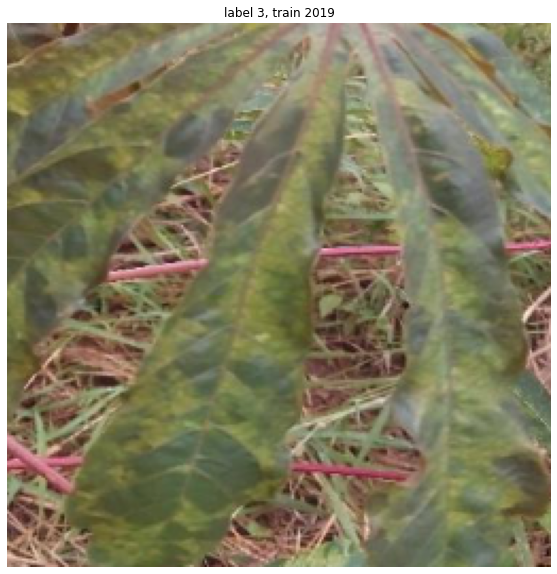

In [15]:
idx = np.random.choice(train_2019_indices)
img, label = train[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, train 2019')
plt.show()

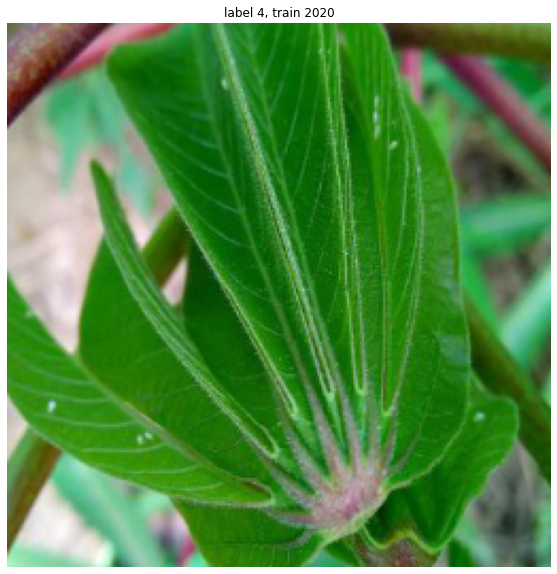

In [16]:
idx = np.random.choice(train_2020_indices)
img, label = train[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, train 2020')

# Train model on 2020 data

In [17]:
train_indices, val_indices = split_data(train_2020, parameters)
indices_2020_train = train_2020_indices[train_indices]
indices_2020_val = train_2020_indices[val_indices]

In [18]:
assert not set(train_indices).intersection(train_2019_indices)

In [19]:
hparams = Namespace(**parameters['classifier'])
model_20 = LeafDoctorModel(hparams)

In [20]:
model_20 = train_model(model_20, train_2020, train_indices, val_indices, parameters)

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/06_models/classifier/checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True


2020-12-25 16:35:42,787 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-25 16:35:42,788 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-25 16:35:42,789 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-25 16:35:42,791 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-25 16:35:46,032 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


Epoch 0: val_acc reached 0.80654 (best 0.80654), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8065.ckpt as top 1


2020-12-25 16:40:48,224 - lightning - INFO - Epoch 0: val_acc reached 0.80654 (best 0.80654), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8065.ckpt as top 1


Epoch 1: val_acc reached 0.83084 (best 0.83084), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8308.ckpt as top 1


2020-12-25 16:45:54,457 - lightning - INFO - Epoch 1: val_acc reached 0.83084 (best 0.83084), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8308.ckpt as top 1


Epoch 2: val_acc was not in top 1


2020-12-25 16:50:57,906 - lightning - INFO - Epoch 2: val_acc was not in top 1


Epoch 3: val_acc reached 0.85016 (best 0.85016), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=3_val_acc=0.8502.ckpt as top 1


2020-12-25 16:56:02,907 - lightning - INFO - Epoch 3: val_acc reached 0.85016 (best 0.85016), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=3_val_acc=0.8502.ckpt as top 1
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.


Epoch 4: val_acc reached 0.86075 (best 0.86075), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8607.ckpt as top 1


2020-12-25 17:01:09,781 - lightning - INFO - Epoch 4: val_acc reached 0.86075 (best 0.86075), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8607.ckpt as top 1


Epoch 5: val_acc was not in top 1


2020-12-25 17:06:11,596 - lightning - INFO - Epoch 5: val_acc was not in top 1


Epoch 6: val_acc reached 0.87227 (best 0.87227), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8723.ckpt as top 1


2020-12-25 17:11:11,355 - lightning - INFO - Epoch 6: val_acc reached 0.87227 (best 0.87227), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8723.ckpt as top 1
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.


Epoch 7: val_acc was not in top 1


2020-12-25 17:16:14,189 - lightning - INFO - Epoch 7: val_acc was not in top 1


Epoch 8: val_acc was not in top 1


2020-12-25 17:21:12,510 - lightning - INFO - Epoch 8: val_acc was not in top 1


Epoch 9: val_acc was not in top 1


2020-12-25 17:26:12,436 - lightning - INFO - Epoch 9: val_acc was not in top 1
Epoch    10: reducing learning rate of group 0 to 1.0000e-06.


Epoch 10: val_acc was not in top 1


2020-12-25 17:31:13,673 - lightning - INFO - Epoch 10: val_acc was not in top 1

2020-12-25 17:31:13,862 - root - INFO - Training finished


In [21]:
torch.save(model_20.state_dict(), 'model_2020_train.pt')

In [22]:
score, model_20_train_preds = score_model(model_20, train_2020, train_indices, parameters)
print('Train score', score)

2020-12-25 17:31:14,129 - root - INFO - Scoring model



2020-12-25 17:31:50,299 - root - INFO - Validation scores:
{'accuracy': 0.895903216937036, 'f1_score': 0.8968279743095713}
Train score {'accuracy': 0.895903216937036, 'f1_score': 0.8968279743095713}


In [23]:
score, model_20_val_preds = score_model(model_20, train_2020, val_indices, parameters)
print('Val score', score)

2020-12-25 17:31:50,307 - root - INFO - Scoring model



2020-12-25 17:31:57,042 - root - INFO - Validation scores:
{'accuracy': 0.8722741433021807, 'f1_score': 0.8734950447830934}
Val score {'accuracy': 0.8722741433021807, 'f1_score': 0.8734950447830934}


In [24]:
score, model_20_test_preds = score_model(model_20, train, train_2019_indices, parameters)
print('2019 score', score)

2020-12-25 17:31:57,050 - root - INFO - Scoring model


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7fb2b8a60>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7fb2b8a60>
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7fb2b8a60>Traceback (most recent call last):

Exception ignored in:   File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7fb2b8a60>Traceback (most recent call last):
    
self._shutdown_workers()    Traceback (most recent call last):
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-


2020-12-25 17:32:06,867 - root - INFO - Validation scores:
{'accuracy': 0.7593680372695969, 'f1_score': 0.748478593434073}
2019 score {'accuracy': 0.7593680372695969, 'f1_score': 0.748478593434073}


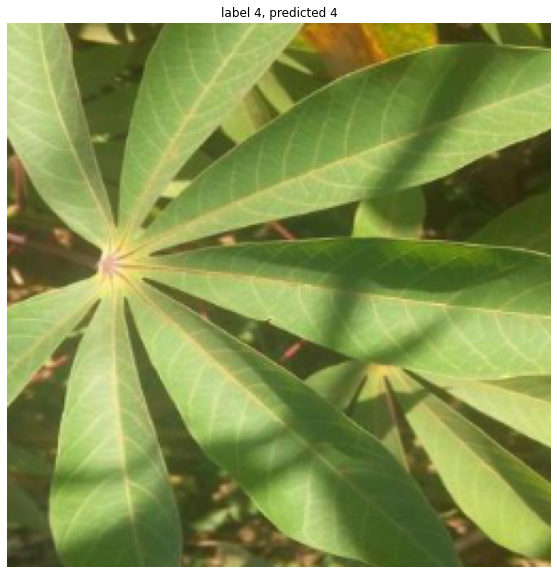

In [25]:
idx = np.random.choice(train_2019_indices)
img, label = train[idx]
predicted = model_20_test_preds[np.argwhere(train_2019_indices == idx)[0][0]]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, predicted {predicted}')
plt.show()

# Train model on 2019 train

In [26]:
train_indices, val_indices = split_data(train_2019, parameters)
indices_2019_train = train_2019_indices[train_indices]
indices_2019_val = train_2019_indices[val_indices]

In [27]:
hparams = Namespace(**parameters['classifier'])
model_19 = LeafDoctorModel(hparams)

In [28]:
model_19 = train_model(model_19, train_2019, train_indices, val_indices, parameters)

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/06_models/classifier/checkpoints exists and is not empty. With save_top_k=1, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True


2020-12-25 17:32:07,242 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-25 17:32:07,243 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-25 17:32:07,244 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-25 17:32:07,245 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-25 17:32:07,376 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


Epoch 0: val_acc reached 0.76248 (best 0.76248), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.7625.ckpt as top 1


2020-12-25 17:33:17,888 - lightning - INFO - Epoch 0: val_acc reached 0.76248 (best 0.76248), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.7625.ckpt as top 1


Epoch 1: val_acc reached 0.80567 (best 0.80567), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8057.ckpt as top 1


2020-12-25 17:34:27,372 - lightning - INFO - Epoch 1: val_acc reached 0.80567 (best 0.80567), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8057.ckpt as top 1


Epoch 2: val_acc reached 0.82726 (best 0.82726), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=2_val_acc=0.8273.ckpt as top 1


2020-12-25 17:36:16,944 - lightning - INFO - Epoch 2: val_acc reached 0.82726 (best 0.82726), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=2_val_acc=0.8273.ckpt as top 1


Epoch 3: val_acc was not in top 1


2020-12-25 17:37:27,224 - lightning - INFO - Epoch 3: val_acc was not in top 1
Epoch     4: reducing learning rate of group 0 to 1.0000e-04.


Epoch 4: val_acc reached 0.86235 (best 0.86235), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8623.ckpt as top 1


2020-12-25 17:38:38,325 - lightning - INFO - Epoch 4: val_acc reached 0.86235 (best 0.86235), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=4_val_acc=0.8623.ckpt as top 1


Epoch 5: val_acc was not in top 1


2020-12-25 17:39:48,808 - lightning - INFO - Epoch 5: val_acc was not in top 1


Epoch 6: val_acc reached 0.87314 (best 0.87314), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8731.ckpt as top 1


2020-12-25 17:41:00,012 - lightning - INFO - Epoch 6: val_acc reached 0.87314 (best 0.87314), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=6_val_acc=0.8731.ckpt as top 1
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.


Epoch 7: val_acc reached 0.87719 (best 0.87719), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=7_val_acc=0.8772.ckpt as top 1


2020-12-25 17:42:11,801 - lightning - INFO - Epoch 7: val_acc reached 0.87719 (best 0.87719), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=7_val_acc=0.8772.ckpt as top 1


Epoch 8: val_acc was not in top 1


2020-12-25 17:43:23,745 - lightning - INFO - Epoch 8: val_acc was not in top 1


Epoch 9: val_acc was not in top 1


2020-12-25 17:44:34,551 - lightning - INFO - Epoch 9: val_acc was not in top 1
Epoch    10: reducing learning rate of group 0 to 1.0000e-06.


Epoch 10: val_acc was not in top 1


2020-12-25 17:45:45,069 - lightning - INFO - Epoch 10: val_acc was not in top 1


Epoch 11: val_acc was not in top 1


2020-12-25 17:46:53,930 - lightning - INFO - Epoch 11: val_acc was not in top 1

2020-12-25 17:46:54,000 - root - INFO - Training finished


In [29]:
torch.save(model_19.state_dict(), 'model_2019_train.pt')

In [30]:
score, model_19_train_preds = score_model(model_19, train_2019, train_indices, parameters)
print('Train score', score)

2020-12-25 17:46:54,413 - root - INFO - Scoring model



2020-12-25 17:47:22,605 - root - INFO - Validation scores:
{'accuracy': 0.9316015252621545, 'f1_score': 0.9323381060940055}
Train score {'accuracy': 0.9316015252621545, 'f1_score': 0.9323381060940055}


In [31]:
score, model_19_val_preds = score_model(model_19, train_2019, val_indices, parameters)
print('Val score', score)

2020-12-25 17:47:22,613 - root - INFO - Scoring model



2020-12-25 17:47:24,941 - root - INFO - Validation scores:
{'accuracy': 0.8758434547908233, 'f1_score': 0.878281670788858}
Val score {'accuracy': 0.8758434547908233, 'f1_score': 0.878281670788858}


In [32]:
score, model_19_test_preds = score_model(model_19, train, train_2020_indices, parameters)
print('2020 score', score)

2020-12-25 17:47:24,948 - root - INFO - Scoring model



2020-12-25 17:48:45,087 - root - INFO - Validation scores:
{'accuracy': 0.7498948352418789, 'f1_score': 0.7494541011143975}
2020 score {'accuracy': 0.7498948352418789, 'f1_score': 0.7494541011143975}


# Get images from 2019 where both models are wrong

In [33]:
# model_19_train_preds
# model_19_val_preds
# model_20_test_preds

In [34]:
indices_2019 = np.concatenate([indices_2019_train, indices_2019_val])
assert (train.sources[indices_2019] == 'train_2019').all()
preds_2019 = np.concatenate([model_19_train_preds, model_19_val_preds])
assert len(indices_2019_train) == len(model_19_train_preds)
assert len(indices_2019_val) == len(model_19_val_preds)
labels_2019 = train.labels[indices_2019]

print('model_2019 on 2019 data accuracy', accuracy_score(preds_2019, labels_2019))

indices_2020 = train_2019_indices
assert (train.sources[indices_2020] == 'train_2019').all()
preds_2020 = model_20_test_preds
labels_2020 = train.labels[train_2019_indices]
assert len(train_2019_indices) == len(preds_2020)

print('model_2020 on 2019 data accuracy', accuracy_score(preds_2020, labels_2020))


errors_2019_model = indices_2019[np.argwhere(preds_2019 != labels_2019).flatten()].flatten()
print(1 - len(errors_2019_model)/len(labels_2019))
errors_2020_model = indices_2020[np.argwhere(preds_2020 != labels_2020)].flatten()
print(1- len(errors_2020_model)/len(labels_2020))

both_errors_2019 = np.array(list(set(errors_2019_model).intersection(set(errors_2020_model))))
both_errors_2019[:10]

model_2019 on 2019 data accuracy 0.9232327324286004
model_2020 on 2019 data accuracy 0.7593680372695969
0.9232327324286004
0.7593680372695969


array([22018, 23557, 23560, 22538, 25613, 21518, 22030, 22547, 21525,
       22038])

<AxesSubplot:title={'center':'Both errors on 2019 class distribution'}>

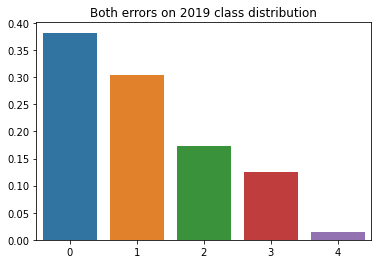

In [35]:
plt.title('Both errors on 2019 class distribution')
sns.barplot(x=[0, 1, 2, 3, 4], y=pd.Series(train.labels[both_errors_2019]).value_counts(normalize=True)[[0, 1, 2, 3, 4]])

## Random error

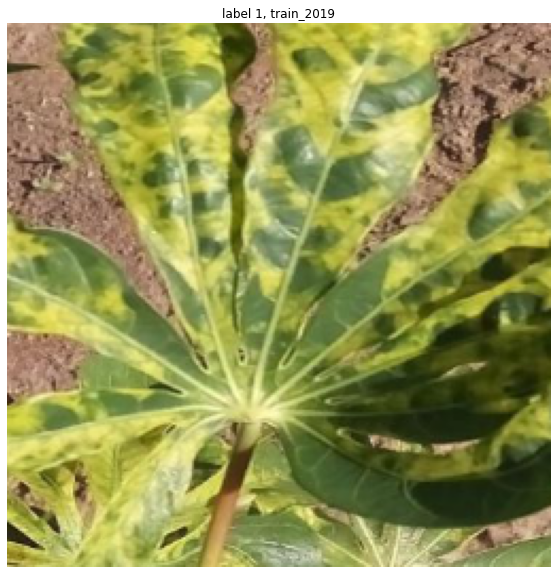

In [88]:
idx = np.random.choice(both_errors_2019)
img, label = train[idx]
source = train.sources[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, {source}')
plt.show()

# Get images from 2020 where both models are wrong

In [37]:
# model_20_train_preds
# model_20_val_preds
# model_19_test_preds

In [38]:
indices_2020 = np.concatenate([indices_2020_train, indices_2020_val])
assert (train.sources[indices_2020] == 'train_2020').all()
preds_2020 = np.concatenate([model_20_train_preds, model_20_val_preds])
assert len(indices_2020_train) == len(model_20_train_preds)
assert len(indices_2020_val) == len(model_20_val_preds)
labels_2020 = train.labels[indices_2020]

print('model_2020 on 2020 data accuracy', accuracy_score(preds_2020, labels_2020))

indices_2019 = train_2020_indices
assert (train.sources[indices_2019] == 'train_2020').all()
preds_2019 = model_19_test_preds
labels_2019 = train.labels[train_2020_indices]
assert len(train_2020_indices) == len(preds_2019)

print('model_2019 on 2020 data accuracy', accuracy_score(preds_2019, labels_2019))


errors_2020_model = indices_2020[np.argwhere(preds_2020 != labels_2020).flatten()].flatten()
print(1 - len(errors_2020_model)/len(labels_2020))
errors_2019_model = indices_2019[np.argwhere(preds_2019 != labels_2019)].flatten()
print(1- len(errors_2019_model)/len(labels_2019))

both_errors_2020 = np.array(list(set(errors_2019_model).intersection(set(errors_2020_model))))
both_errors_2020[:10]

model_2020 on 2020 data accuracy 0.8923580275765366
model_2019 on 2020 data accuracy 0.7498948352418789
0.8923580275765366
0.7498948352418789


array([    0,  8193,     2,  8195, 16388, 16389,     7,     8, 16394,
          18])

<AxesSubplot:title={'center':'Both errors on 2020 class distribution'}>

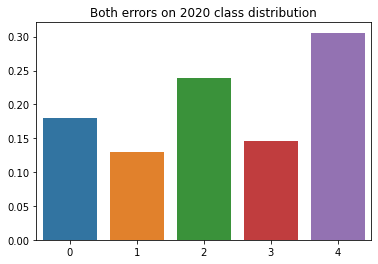

In [39]:
plt.title('Both errors on 2020 class distribution')
sns.barplot(x=[0, 1, 2, 3, 4], y=pd.Series(train.labels[both_errors_2020]).value_counts(normalize=True)[[0, 1, 2, 3, 4]])

## Random error

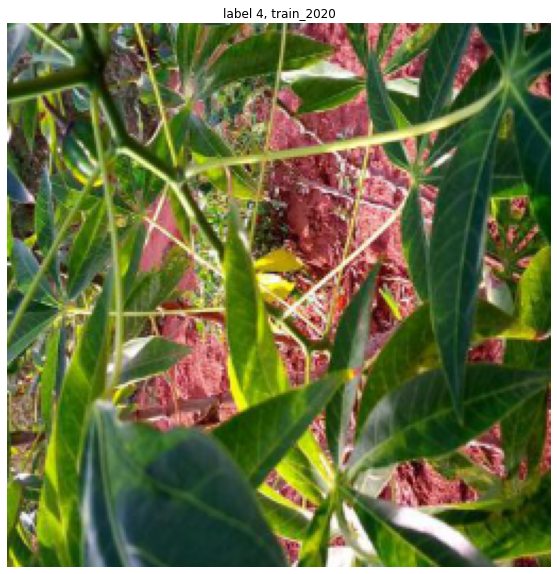

In [149]:
idx = np.random.choice(both_errors_2020)
img, label = train[idx]
source = train.sources[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, {source}')
plt.show()